In [1]:
import numpy as np
from matplotlib import pyplot as plt
#from math import sqrt
from cmath import sqrt

In [2]:
plt.rcParams["figure.dpi"] = 300

# Trying to Recreate Beamforming

### FIRST METHOD

In [3]:
# See http://mathscinotes.com/2012/01/beamforming-math/ for explanation.
π = np.pi
num_points = 500
s_k = 100
def dist(k,θ,r,N,λ) :
    '''
    Calculates the distance from the array element (middle of the antenna array is origin) to the transmitter
    which is r away from the origin.
    
    Inputs:
        k (int)       - index of antenna
        θ (rad)       - angle off from orthogonal to array
        r (unit-less) - distance to transmitter from origin
        N (int)       - number of antenna
        λ (?)         - wavelength (c = fλ where c is the speed of light and f is the frequency)
        
    Output:
        Distance from antenna to transmitter
    '''
    dx = k*λ/2 - (N-1)*λ/4
    x = np.sin(θ)*r # Might need to be sin
    y = np.cos(θ)*r # Might need to be cos
    return sqrt((x-dx)**2+y**2)

def calc_coeffs(θ,N,r,λ) :
    '''
    Calculates the coefficients of the beam equation
    
    Inputs:
        θ (rad) - angle off from orthogonal to array
        N (int) - number of antenna
    
    Output:
        a_k for the beam form equation Σ_1^N <a_k(θ), x_k> where x_k is the volatge response of antenna k
        NOTE: This vector is normalized (why? I don't know)
    '''
    ϕ = π*np.sin(θ)
    bs = np.zeros(N).astype(complex)
    for k in range(N) :
        #ϕ = 2*π*dist(k,θ,r,N,λ)/λ 
        bs[k] = np.exp(ϕ*k*1j)
    return bs/np.linalg.norm(bs)

def dst(θ,r,N,λ) :
    ds = np.zeros(N).astype(complex)
    for k in range(N) :
        ds[k] = np.exp(dist(k,θ,r,N,λ)*2*π*1j)
    ds = ds/np.linalg.norm(ds)
    return ds

def weights(θ,N,r,λ) :
    '''
    Calculates the coefficients of the beam equation
    
    Inputs:
        θ (rad) - angle off from orthogonal to array (off x-axis)
        N (int) - number of antenna +1
    
    Output:
        a_k for the beam form equation Σ_1^N <a_k(θ), x_k> where x_k is the volatge response of antenna k
        NOTE: This vector is normalized (why? I don't know)
    '''
    ϕ = π*np.sin(θ)
    bs = np.zeros(N).astype(complex)
    for k in range(N) :
        bs[k] = np.exp(ϕ*k*1j)
    return bs/np.linalg.norm(bs)

def gen_beam(θ):
    '''
    Generates a beam of the form [power_levels (n,) array, weights (N,) array] for a beam aiming in the
    direction of θ
    
    Inputs :
        θ (rad) - The angle off the x-axis for the beam
        
    Output :
        beam (as described above)
    '''
    if θ < 0 :
        θ += 2*π
    angles = np.linspace(0,2*π,num_points)
    ak = weights(θ,N,s_k,λ)
    sig_beam = [abs(dst(angle,s_k,N,λ)@ak) for angle in angles]
    beam = [sig_beam,ak]
    return beam

def get_angle_range(θ) :
    '''
    Determines [θ_min,θ_max] for sending the packets.
    
    Input :
        θ (rad) - The angle off the x-axis to Bob's location.
    
    Output :
        θ_min, θ_max (rad) - The minimum and maximum angle to choose for beamforming.
    '''
    optimal_beam = gen_beam(θ)[0]
    # Get values that are greater than half power
    mask = optimal_beam >= 0.25*max(optimal_beam)
    # Do 2π to 4π to avoid problems, fix it later.
    θs = np.linspace(2*π,4*π,num_points)*mask
#     print(f'To BOB: {θ}\n',θs)
    # Get the interval
    int_found = False
    iters = 0
    while not int_found and iters <= num_points :
        θ_min_ind = next((i for i, x in enumerate(θs) if x != 0), None)
#         print(f'First: {θ_min_ind}')
        #This is to handle the beam beginning with the interval (loops back)
        if θ_min_ind is not None and θ_min_ind == 0 and θs[-1] != 0 :
            ϕs = θs[::-1]
            θ_min_ind = -next((i for i, x in enumerate(ϕs) if x == 0), 0)
#             print(f'Update first: {θ_min_ind}')
        elif θ_min_ind is None :
            return θ, None # SOMETHING WENT WRONG
        if θ_min_ind >= 0 :
            θ_max_ind = next((i for i, x in enumerate(θs[θ_min_ind:]) if x == 0), -θ_min_ind) + θ_min_ind - 1
        else : 
            θ_max_ind = next((i for i, x in enumerate(θs) if x == 0), None)
            if θ_max_ind is None :
                raise ValueError('Interval could not be found.') # SOMETHING WENT WRONG
            else :
                θ_max_ind -= 1
#         print(θ_max_ind)
#         print(θs[θ_min_ind],θs[θ_max_ind])
#         print(θ+2*π)
        if θ_min_ind < 0 :
            θ_min = θs[θ_min_ind] - 4*π
        else :
            θ_min = θs[θ_min_ind] - 2*π
        θ_max = θs[θ_max_ind] - 2*π
        if (θ >= θ_min and θ <= θ_max) or ((θ-2*π) >= θ_min and (θ-2*π) <= θ_max) :
            int_found = True
        else :
            if θ_min_ind < 0 :
                θs[θ_min_ind:] = 0
                θs[:θ_max_ind+1] = 0
            elif θ_max_ind == -1 :
                θs[θ_min_ind:] = 0
            else :
                θs[θ_min_ind:θ_max_ind+1] = 0
#             print('Wrong Interval')
        iters += 1
    if θ_max == 0 :
        θ_max = 2*π
#     print(θ_min,θ_max)
    return θ_min,θ_max

In [6]:
N = 7                            # Number of antenna
λ = 1                            # Wavelength
r = s_k*λ                        # Distance to transmitter
θs = np.linspace(0,2*π,1000)
problem_angles = []
for beam_θ in θs :
    #beam_θ = 2*π/3                     # Desired azmith angle
#     ak = calc_coeffs(beam_θ,N,r,λ)
#     res = []
#     for θ in θs :
#         ds = dst(θ,r,N,λ)
#         res.append(abs(ds@ak))
    #plt.polar(θs,res)
    #plt.show()
    θ_min, θ_max = get_angle_range(beam_θ)
    if θ_max is None or θ_min is None :
        problem_angles.append(beam_θ)
    else :
        problem_angles.append(None)
#print(problem_angles)

In [7]:
print(problem_angles.count(None)/len(problem_angles))

1.0


In [16]:
print(problem_angles)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [20]:
θ_min, θ_max = get_angle_range(6.058)

To BOB: 6.058
 [ 6.28318531  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.      

### SECOND METHOD

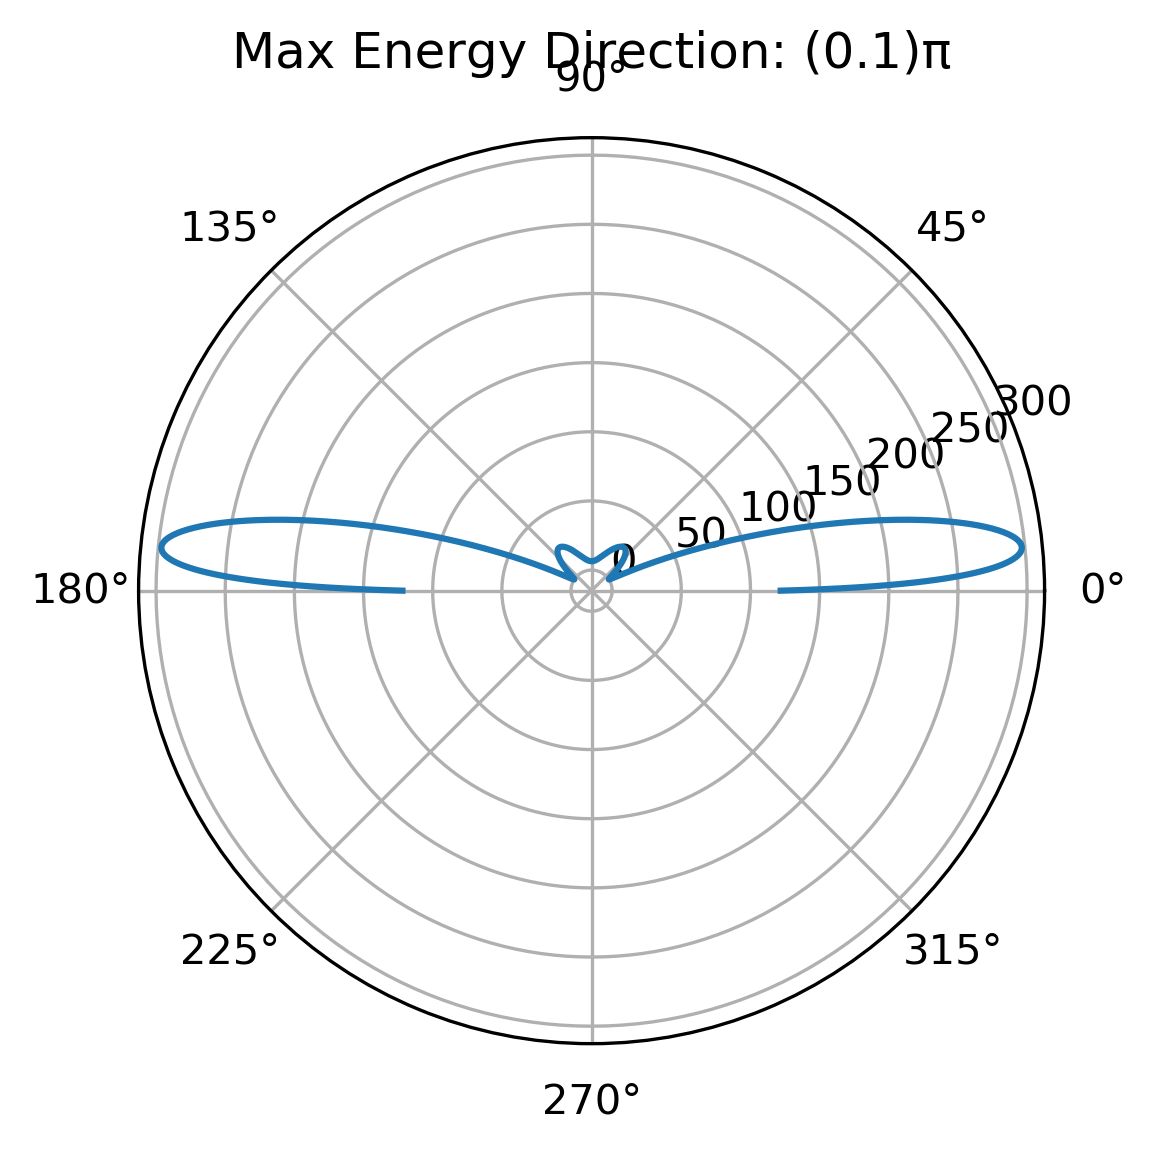

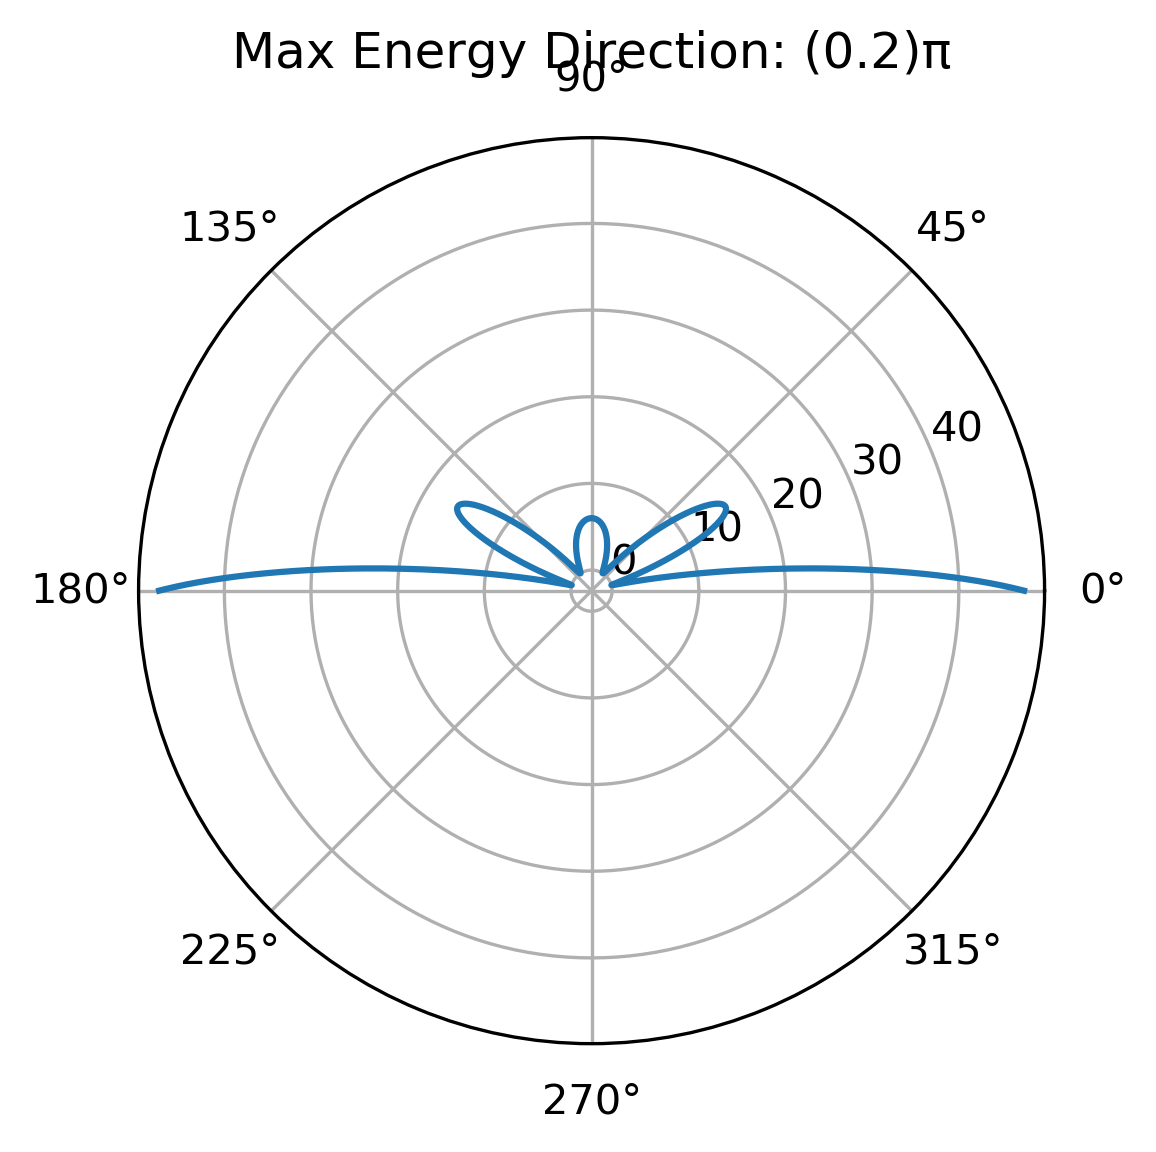

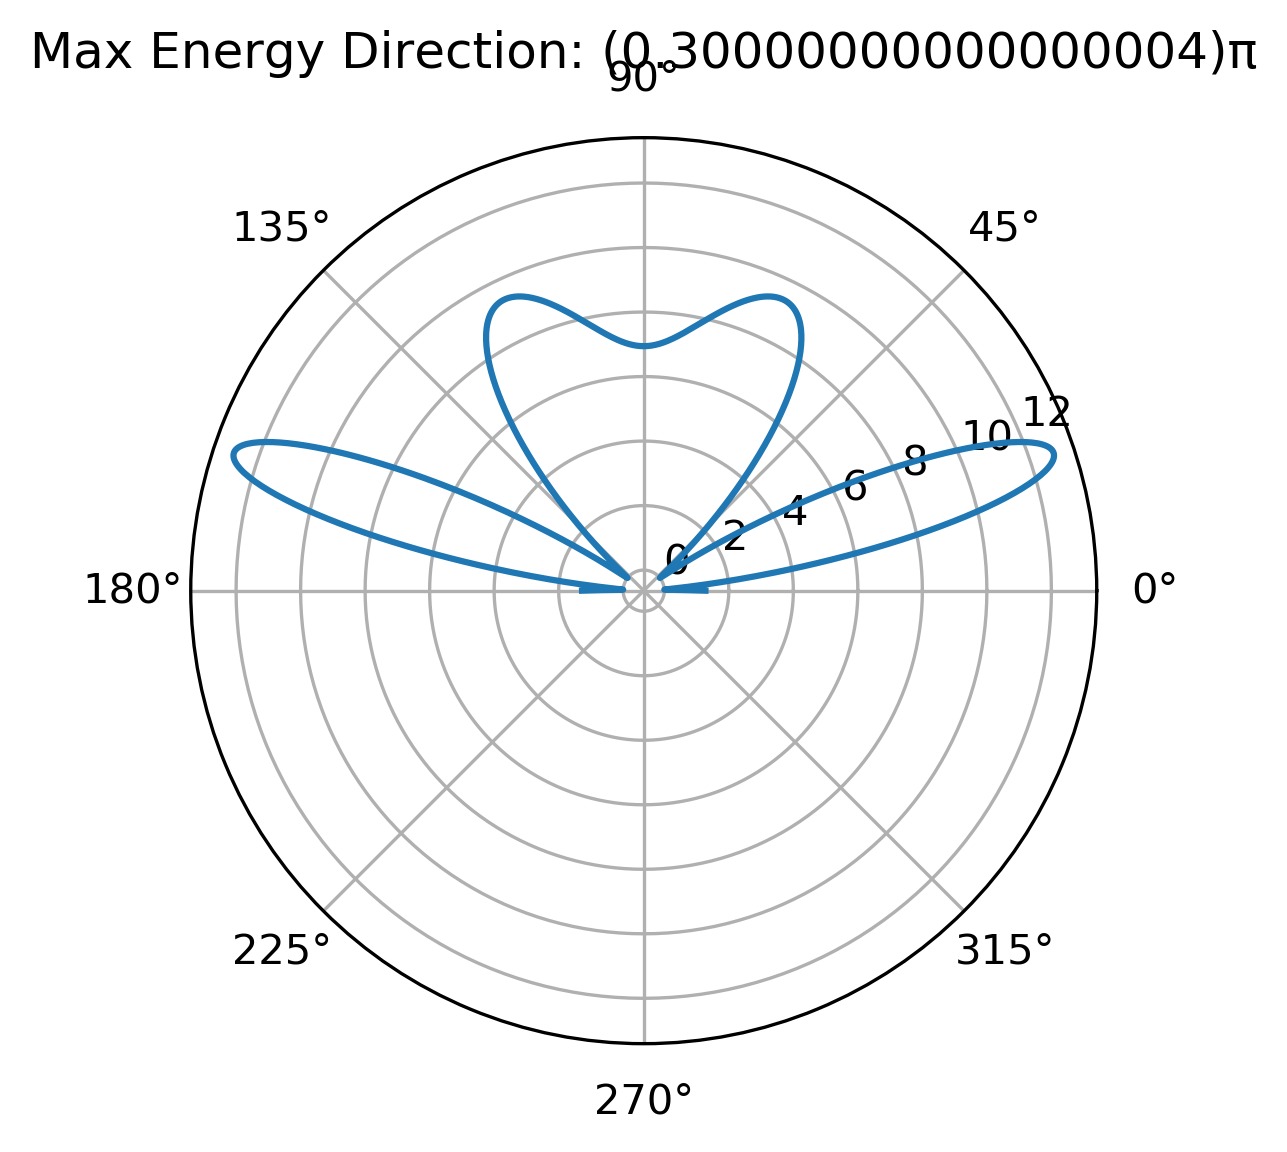

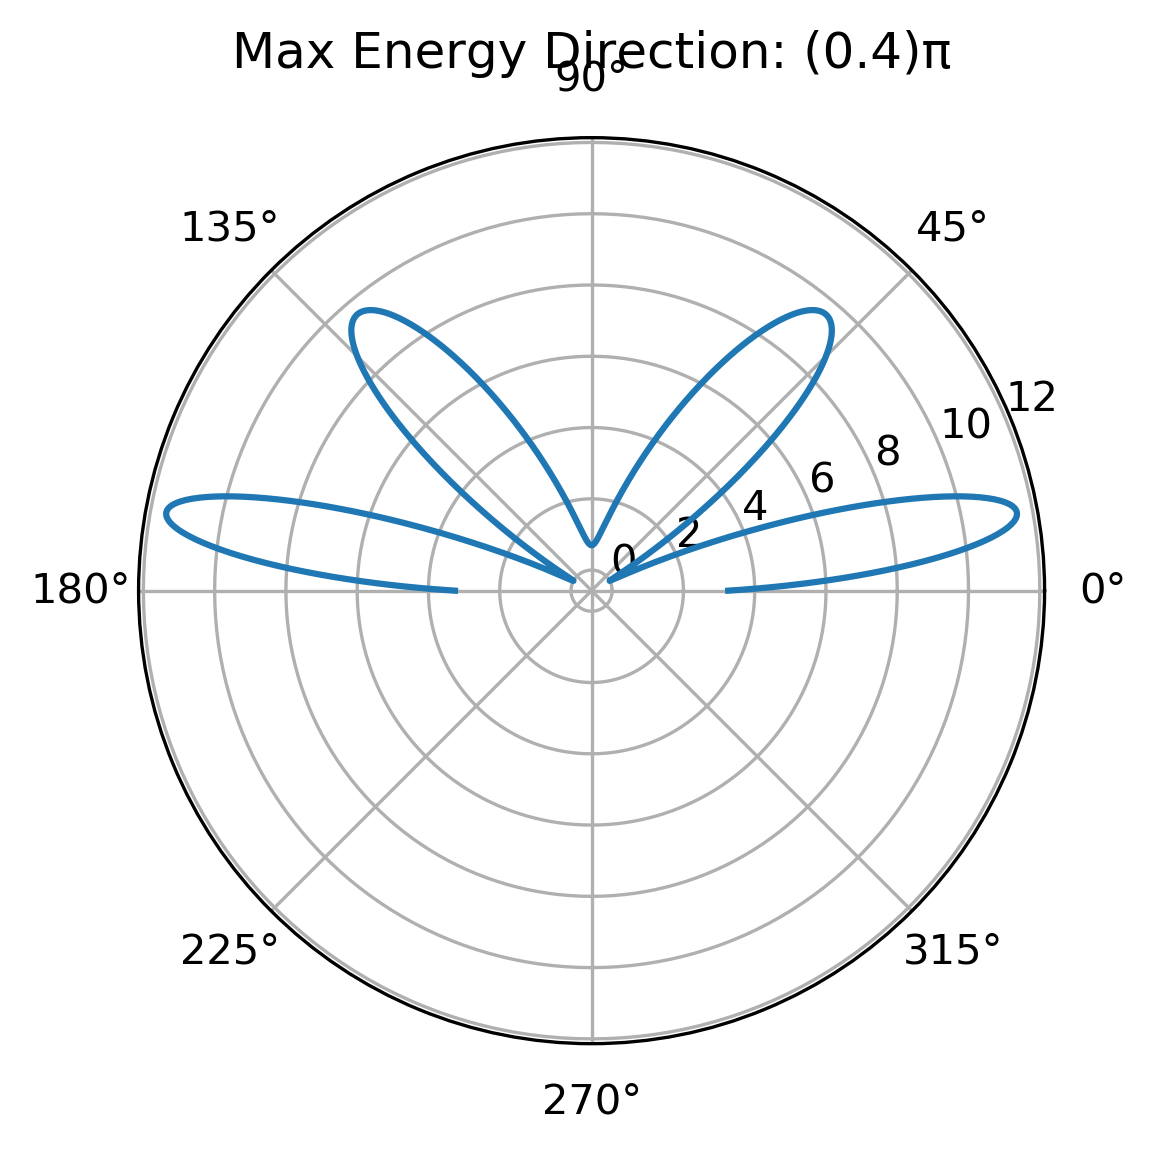

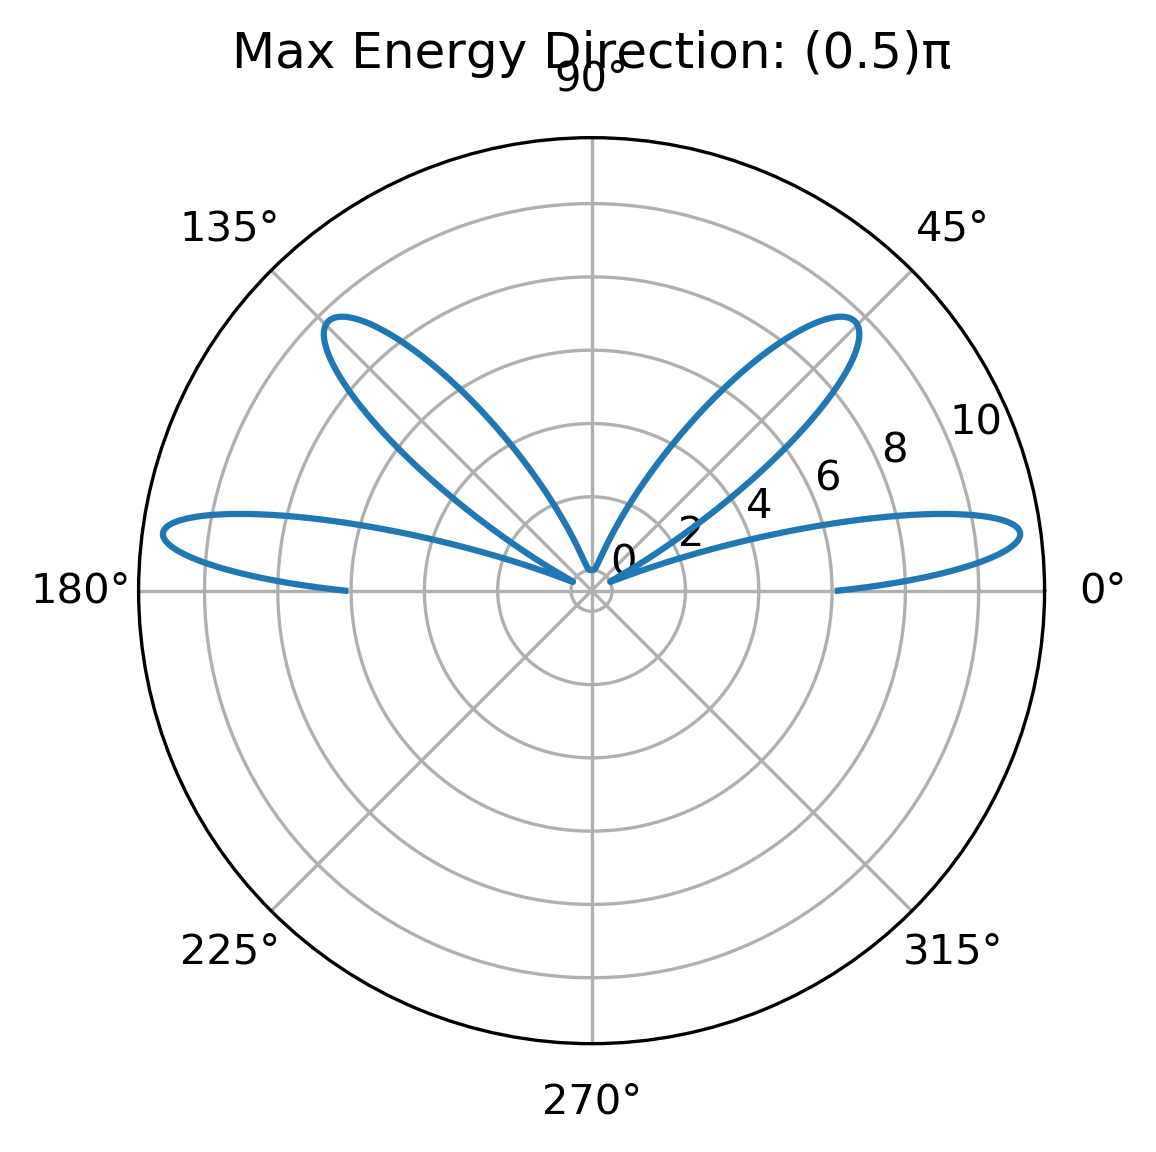

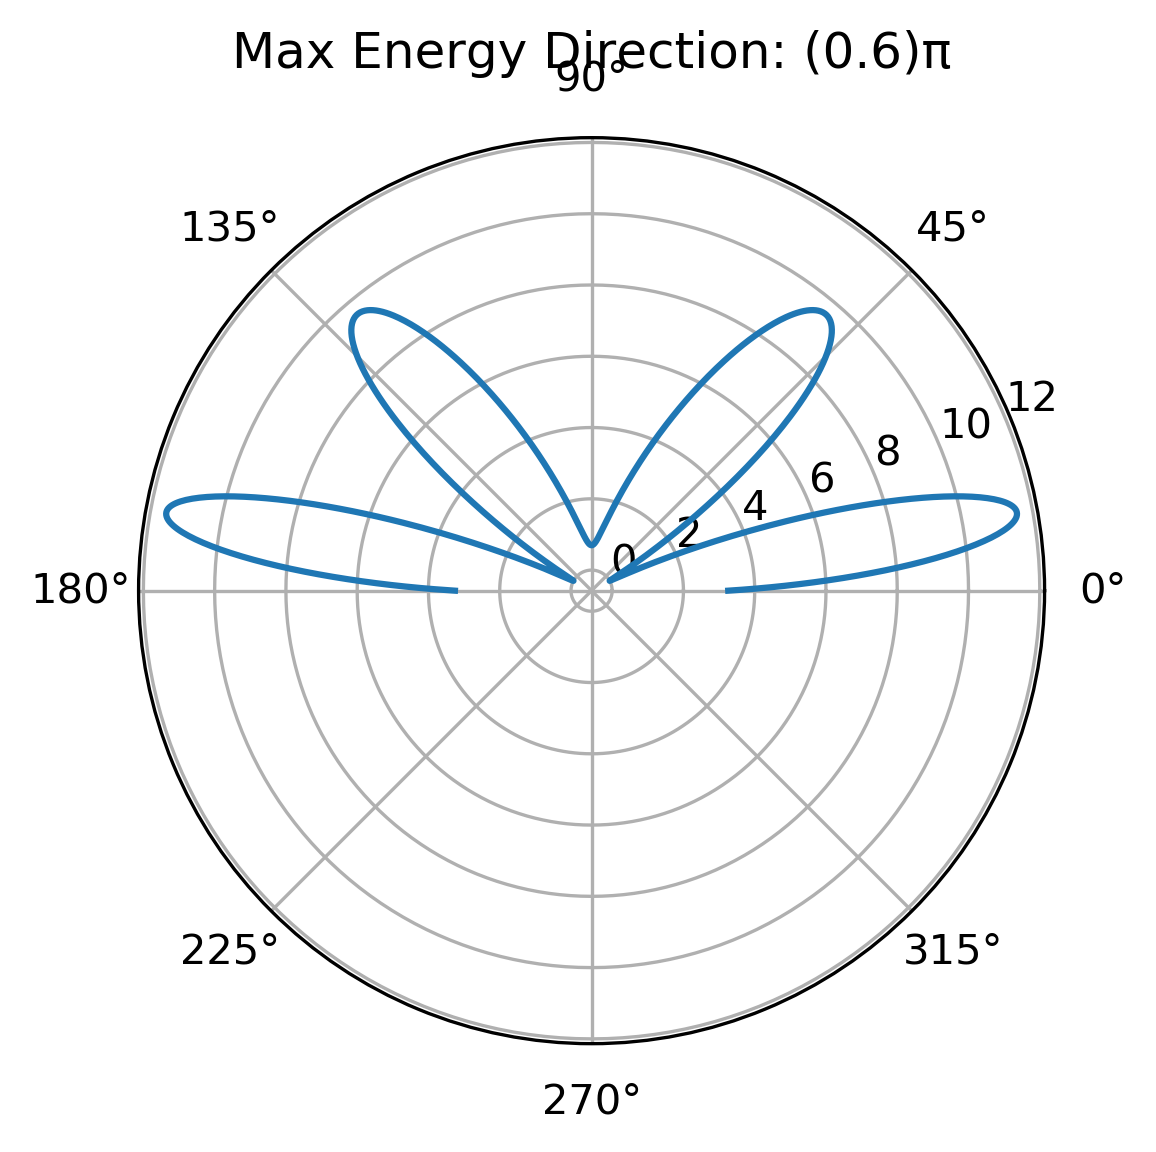

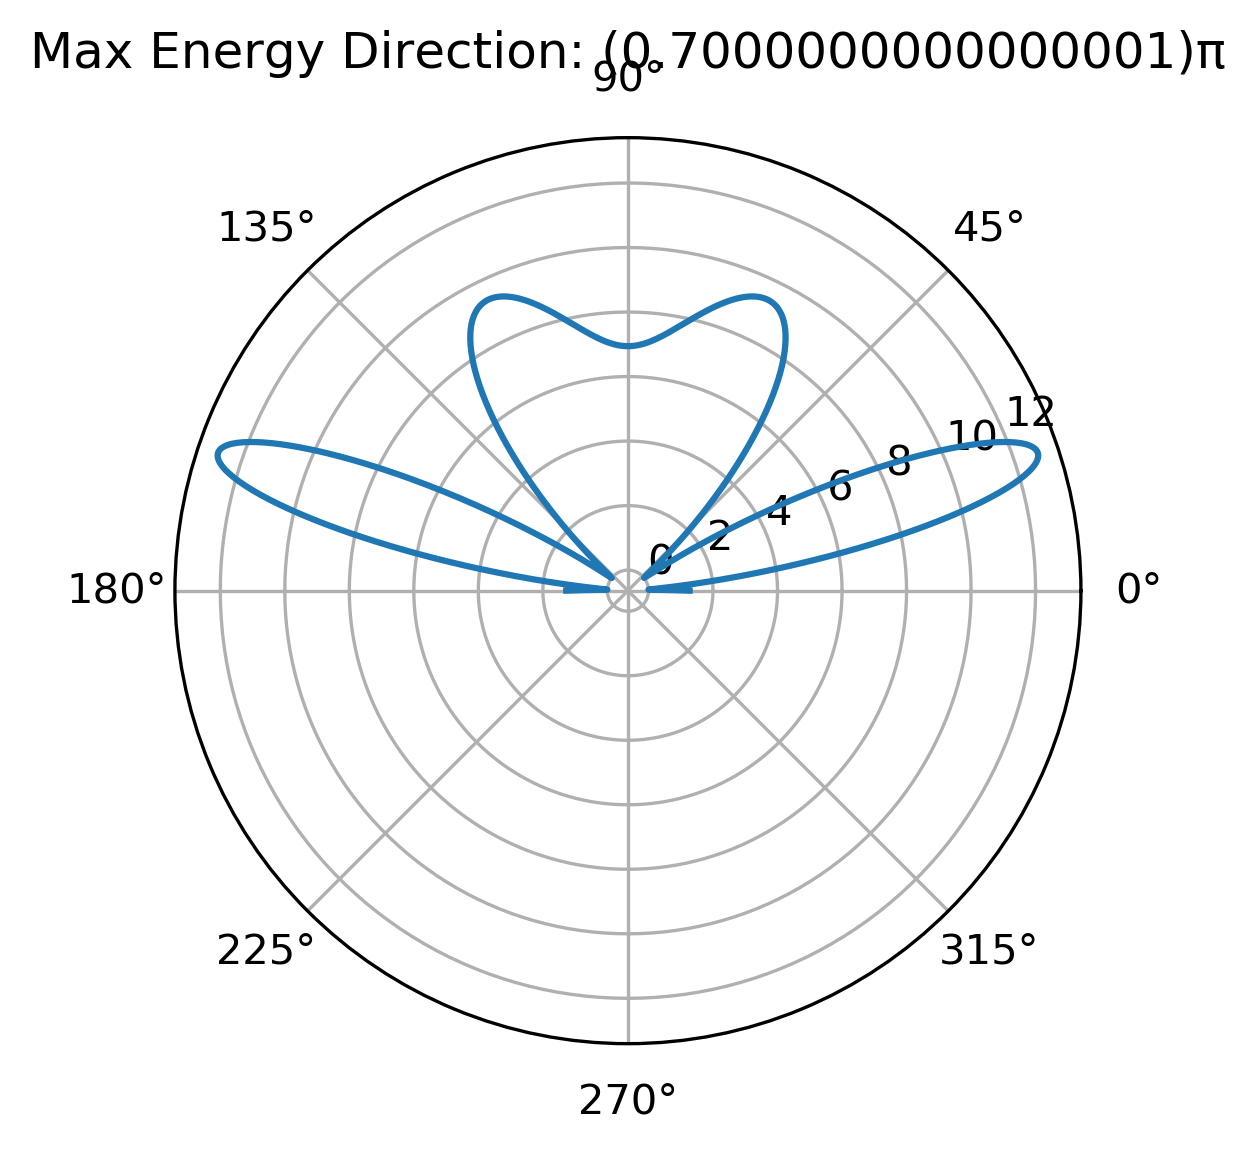

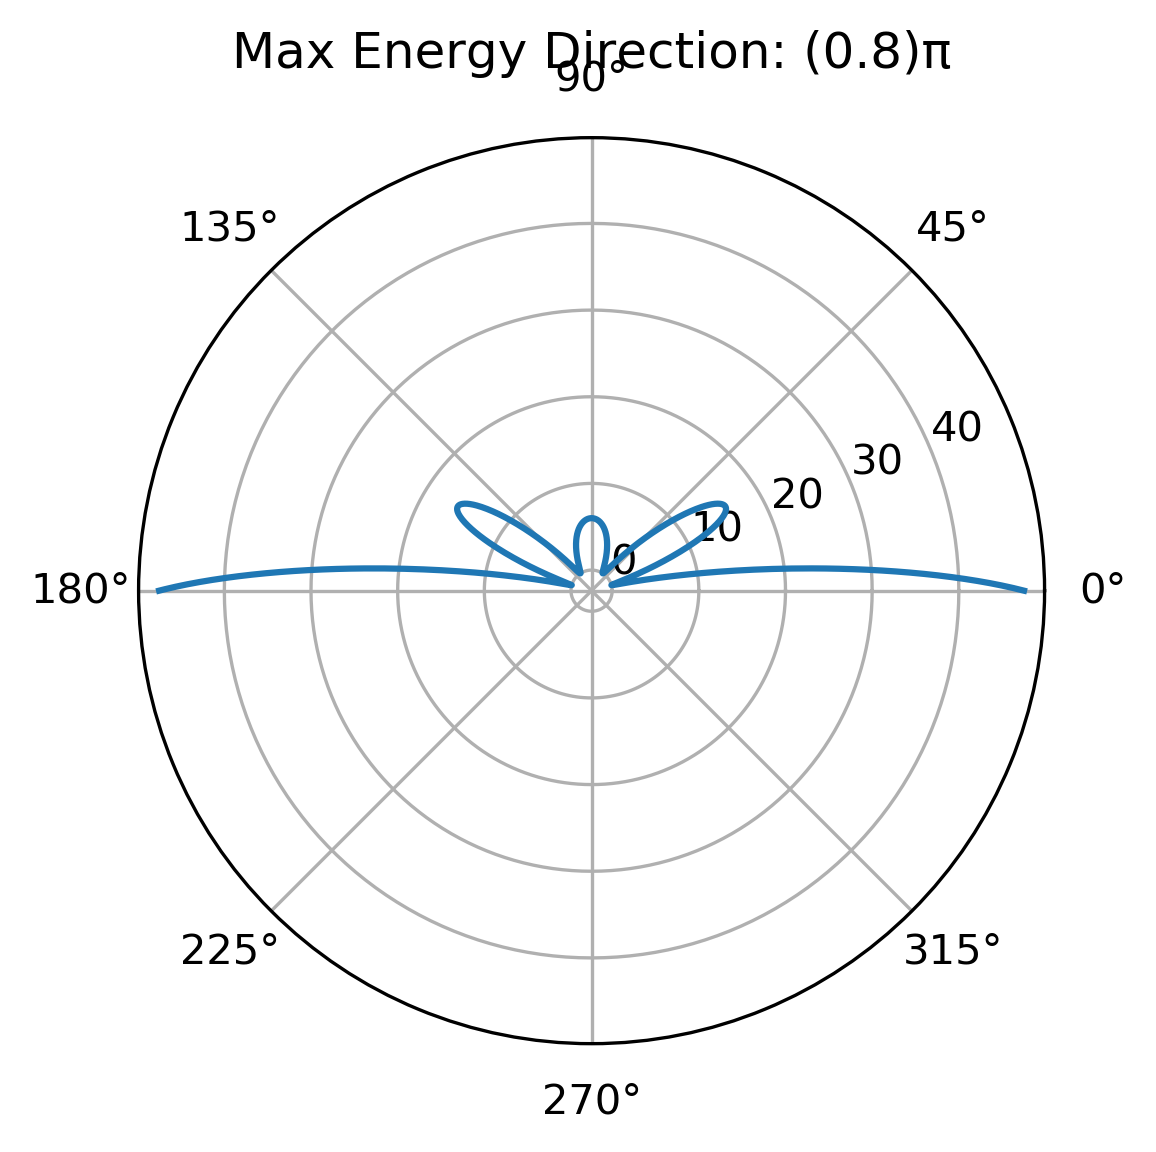

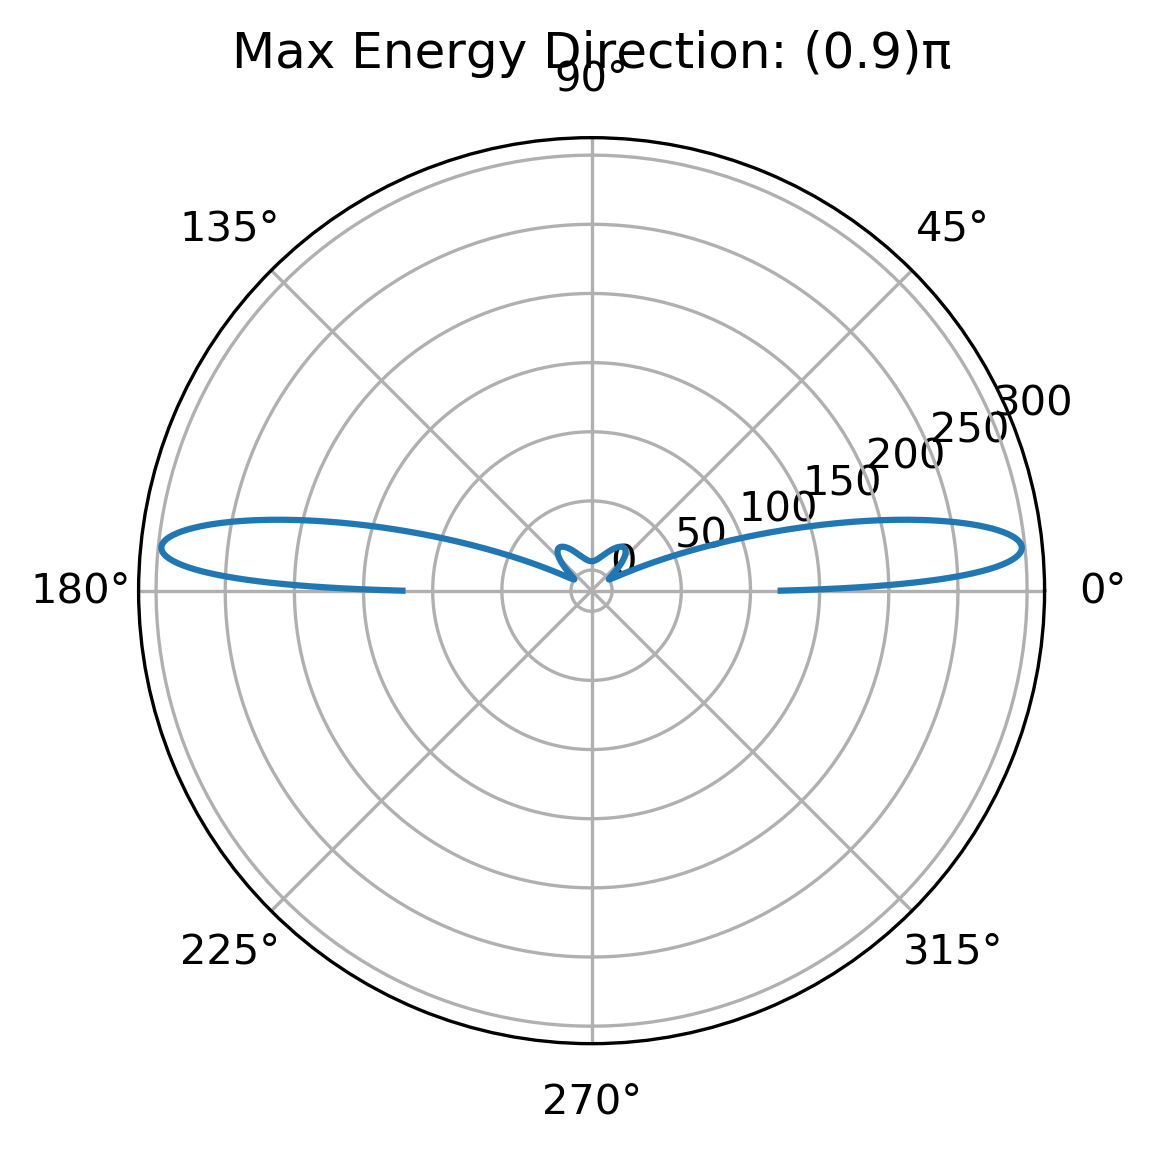

In [13]:
# This calculation is done using the forumula at https://en.wikipedia.org/wiki/Phased_array
I_0 = 10 # Initial Power
λ = 10   # Wavelength
d = λ/4  # Distance between antenna
a = 0.5  # Size of antenna
N = 7    # Number of antenna
θ = np.linspace(0,π,1000)
directions = np.linspace(0.1,0.9,9) # Directions to point the beam
for dr in directions :
    max_en_dir = dr*π
    ϕ = 2*π*d/λ*np.sin(max_en_dir) - π/N
    coeff = I_0*(np.sinc(π*a/λ*np.sin(θ))**2)
    I = coeff*(np.sin((π/λ)*d*N*np.sin(θ) + (N/2)*ϕ)/np.sin((π/λ)*d*np.sin(θ)+ϕ))**2
    plt.polar(θ,I)
    plt.title(f'Max Energy Direction: ({dr})π')
    plt.show()

In [14]:
L = d*(N-1)+N*a
print(2*L**2/λ) # r > this value

68.45


### THIRD METHOD

In [15]:
def f(func,C) :
    '''
    If C = UΣU.T, then f(C) = Uf(Σ)U.T = U*diag(func(σ_1),...,func(σ_2))*U.T
    
    Inputs :
        func - Callable scalar function
        C    - Cross Spectral Matrix of a system
        
    Output :
        f(C) as defined in description
    '''
    eigv, U = np.linalg.eig(C)
    f_eigs = [func(eig) for eig in eigv]
    return U@np.diag(f_eigs)@U.T

def calc_coeffs(θ,N,r,λ) :
    '''
    Calculates the coefficients of the beam equation
    
    Inputs:
        θ (rad) - angle off from orthogonal to array
        N (int) - number of antenna +1
    
    Output:
        a_k for the beam form equation Σ_1^N <a_k(θ), x_k> where x_k is the volatge response of antenna k
        NOTE: This vector is normalized (why? I don't know)
    '''
    ϕ = -π*np.sin(θ) # Why is this negative?
    bs = np.zeros(N)
    for k in range(N) :
        #ϕ = 2*π*dist(k,θ,r,N,λ)/λ 
        bs[k] = np.exp(ϕ*k*1j)
    return bs/np.linalg.norm(bs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


ν = 1
7.24% of angles are less than or equal to 0.05
Effective bandwidth (1/2 power) is 6.547724814664301.


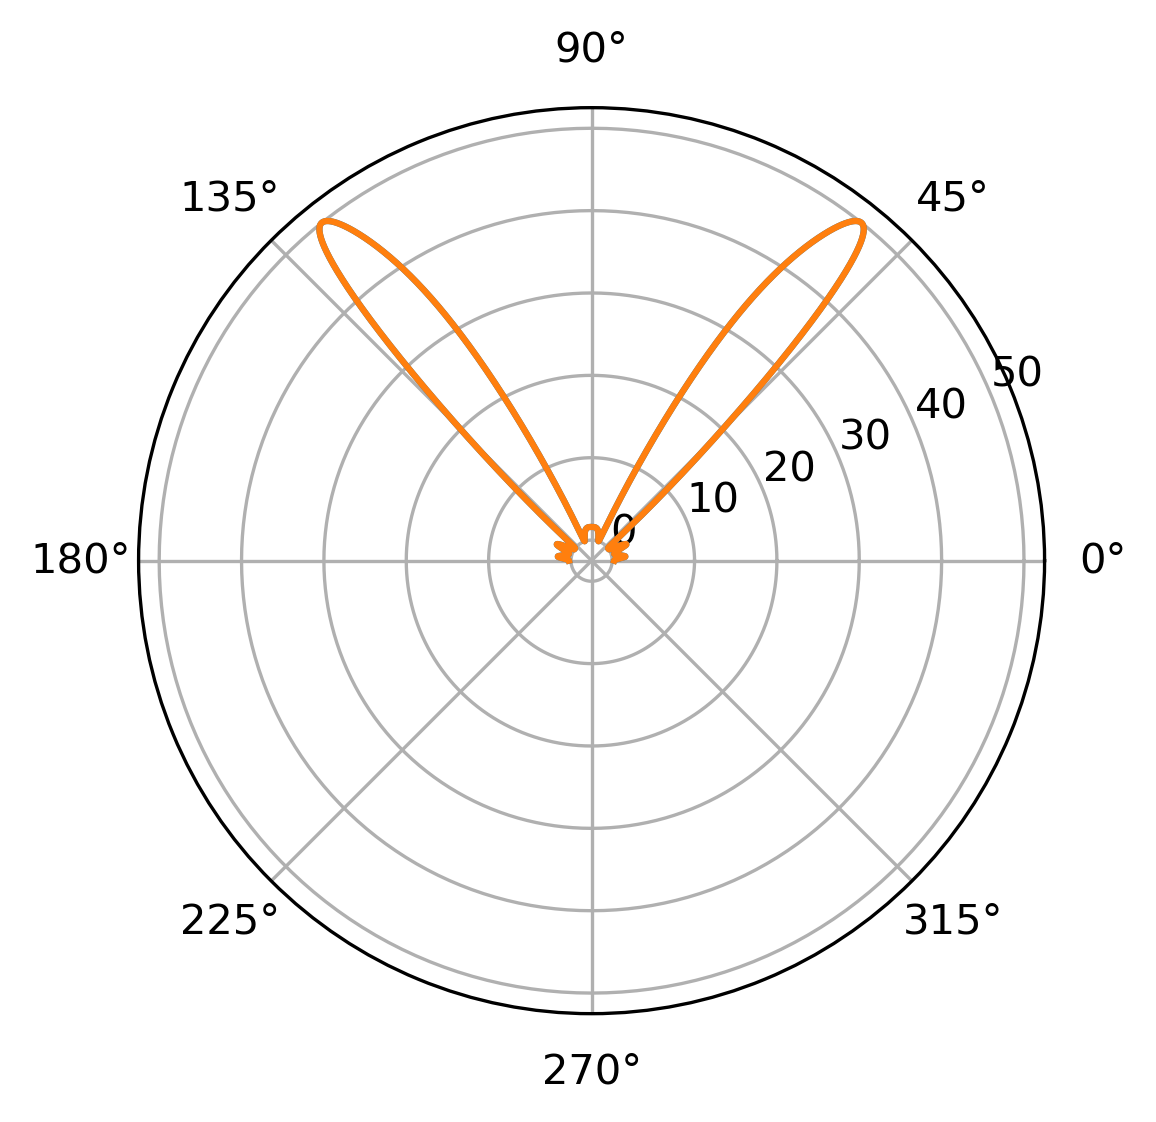

ν = 11
83.89999999999999% of angles are less than or equal to 0.05
Effective bandwidth (1/2 power) is 2.080912098594938.


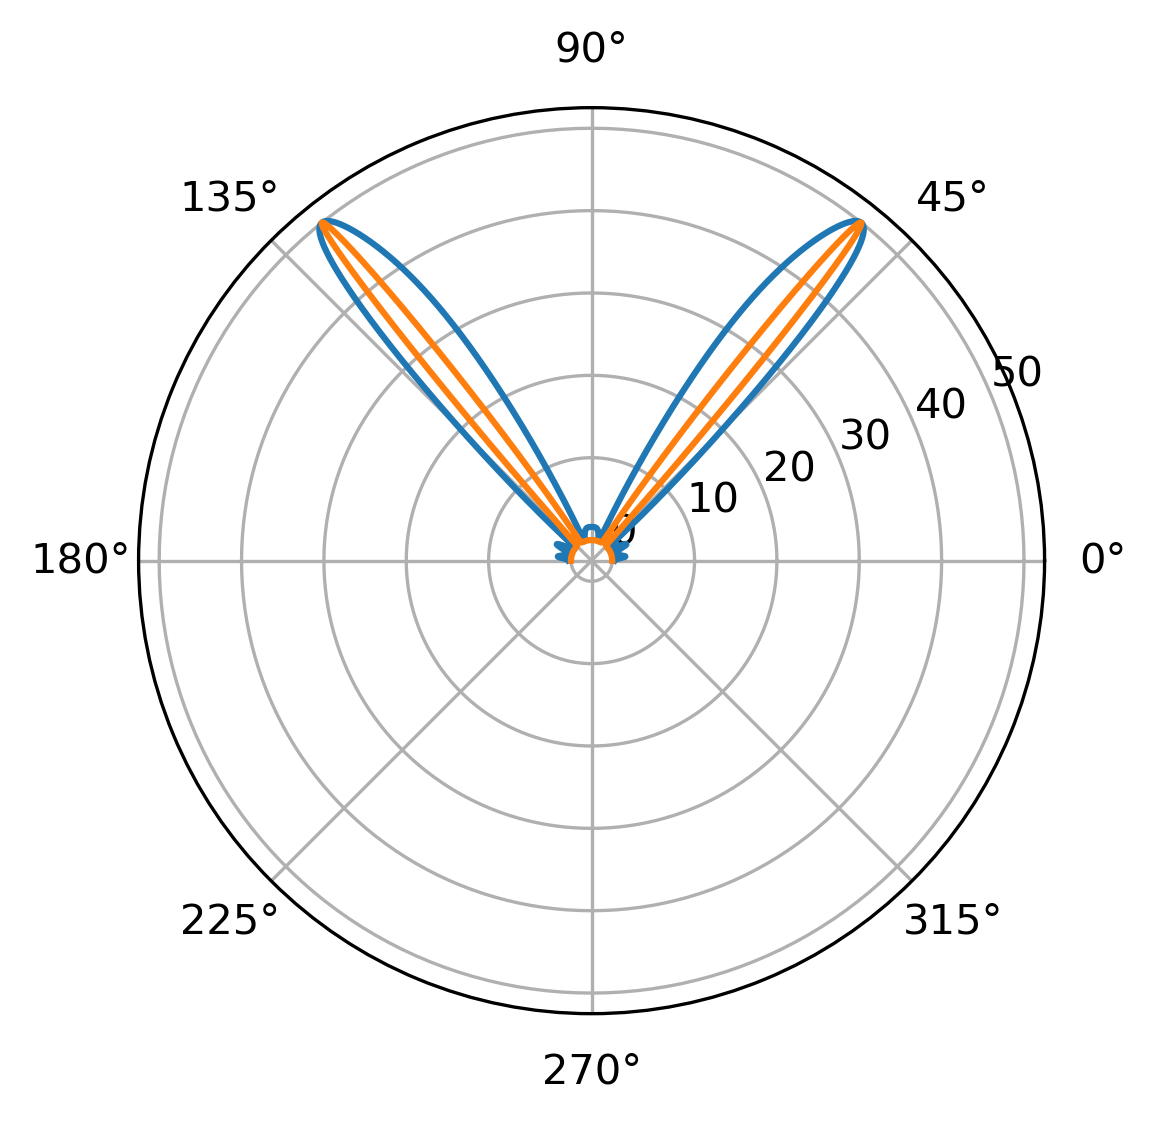

ν = 21
87.8% of angles are less than or equal to 0.05
Effective bandwidth (1/2 power) is 1.492184161040771.


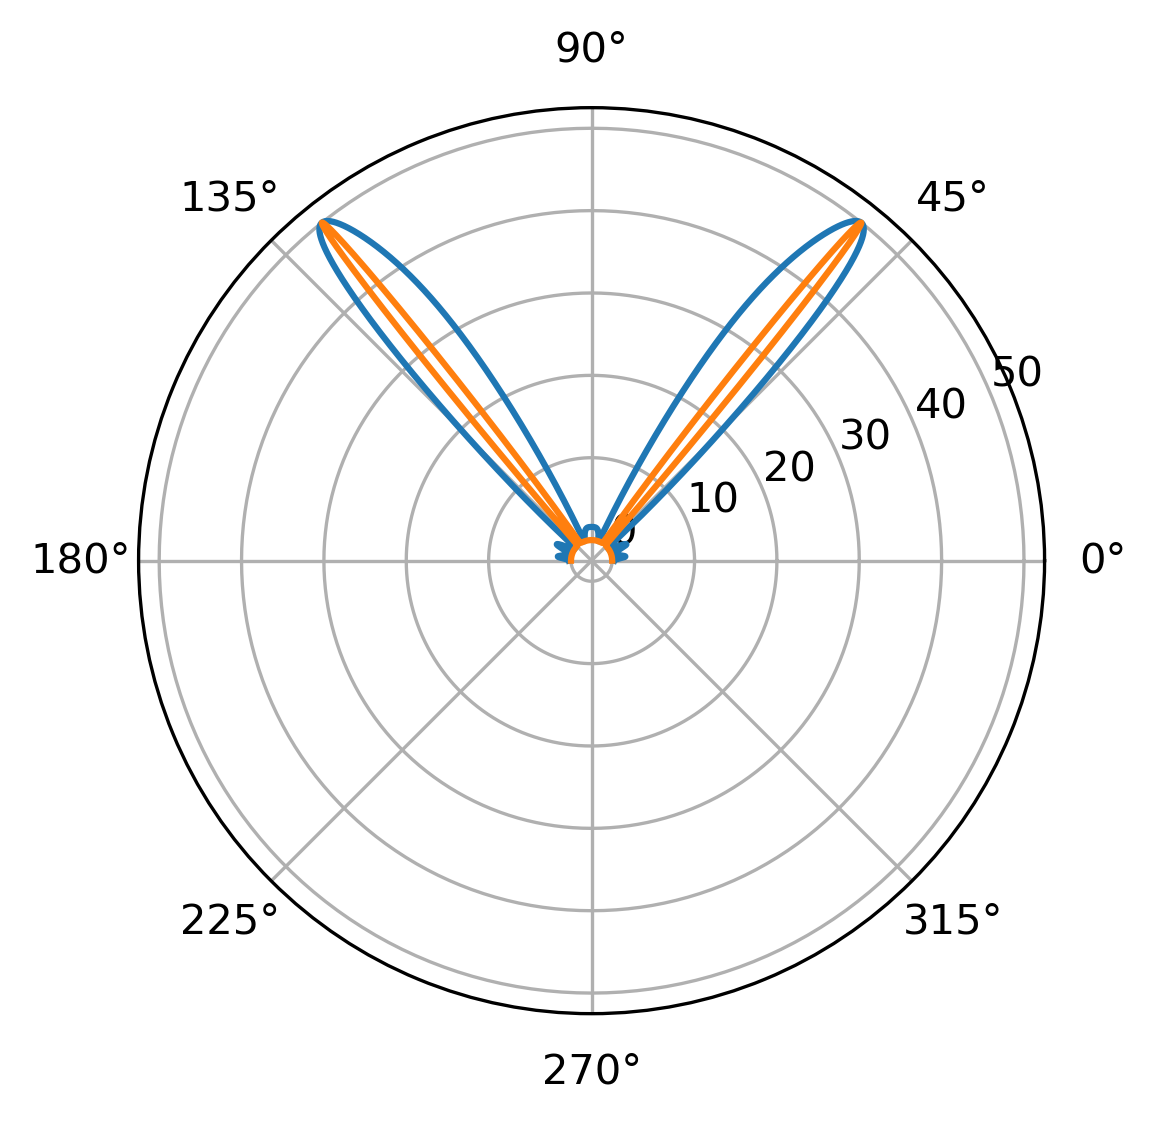

ν = 31
89.86% of angles are less than or equal to 0.05
Effective bandwidth (1/2 power) is 1.2173685951556465.


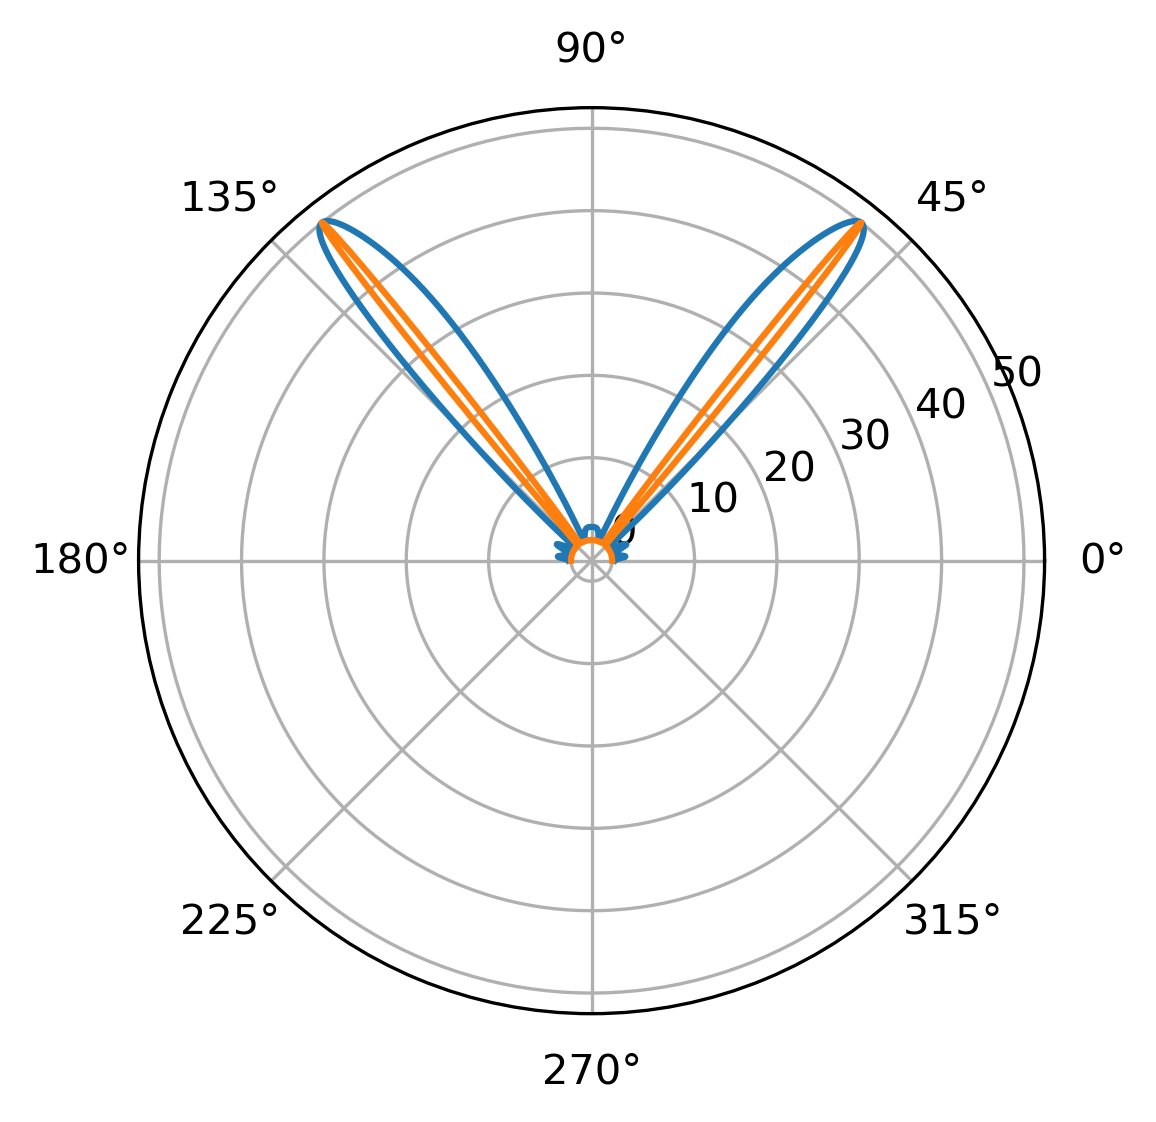

ν = 41
91.18% of angles are less than or equal to 0.05
Effective bandwidth (1/2 power) is 1.0524610583957683.


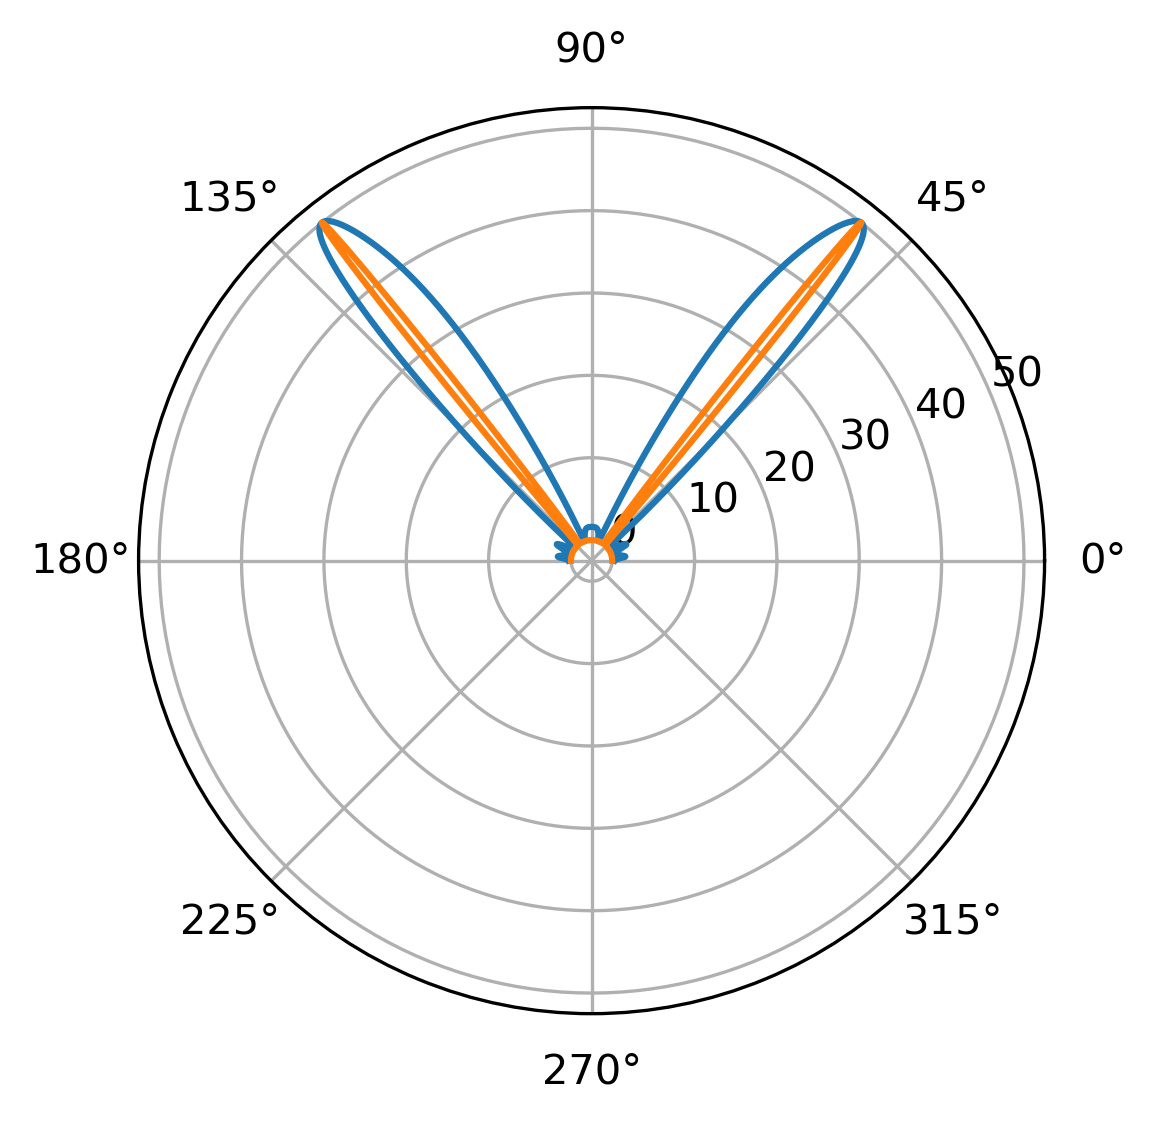

In [29]:
# Trying to use the information in http://www.bebec.eu/Downloads/BeBeC2014/Papers/BeBeC-2014-01.pdf
N = 7                            # Number of antenna
λ = 1                            # Wavelength
num_points = 10000
practically_zero_dB = 0.05
θs = np.linspace(0,π,num_points)
beam_θ = 5*π/7                     # Desired azmith angle
ak = calc_coeffs(beam_θ,N,r,λ)
s_k = 50                         # Alice's signal strength
g_k = np.array(ak).reshape(1,N)  # Direction of Alice's transmitter relative to Bob (in this case, beam_θ)
b = lambda g,n=1 : s_k*(float(g_k@g))**(2*n)
C = s_k*(np.dot(g_k.T,g_k))      # Cross Spectral Matrix
res1 = [b(calc_coeffs(θ,N,s_k,λ)) for θ in θs]
for i in range(1,51,10) :
    print(f'ν = {i}')
    res2 = []
    for θ in θs :
        steer_coeffs = calc_coeffs(θ,N,s_k,λ)
        res2.append(b(steer_coeffs,i))
    mask = np.array(res2) <= practically_zero_dB
    perc = sum(mask)/num_points*100
    print(f'{perc}% of angles are less than or equal to {practically_zero_dB}')
    bd_mask = list(np.array(res2) >= s_k/2)
    ind1 = bd_mask.index(True)
    ind2 = bd_mask[ind1:].index(False) + ind1 - 1 # Do a small example to see why this is true.
    bd_angle = θs[ind2] - θs[ind1]
    bd_w = np.sin(bd_angle)*s_k/(2*np.sin((π-bd_angle)/2))
    print(f'Effective bandwidth (1/2 power) is {bd_w}.')
    plt.polar(θs,res1)
    plt.polar(θs,res2)
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


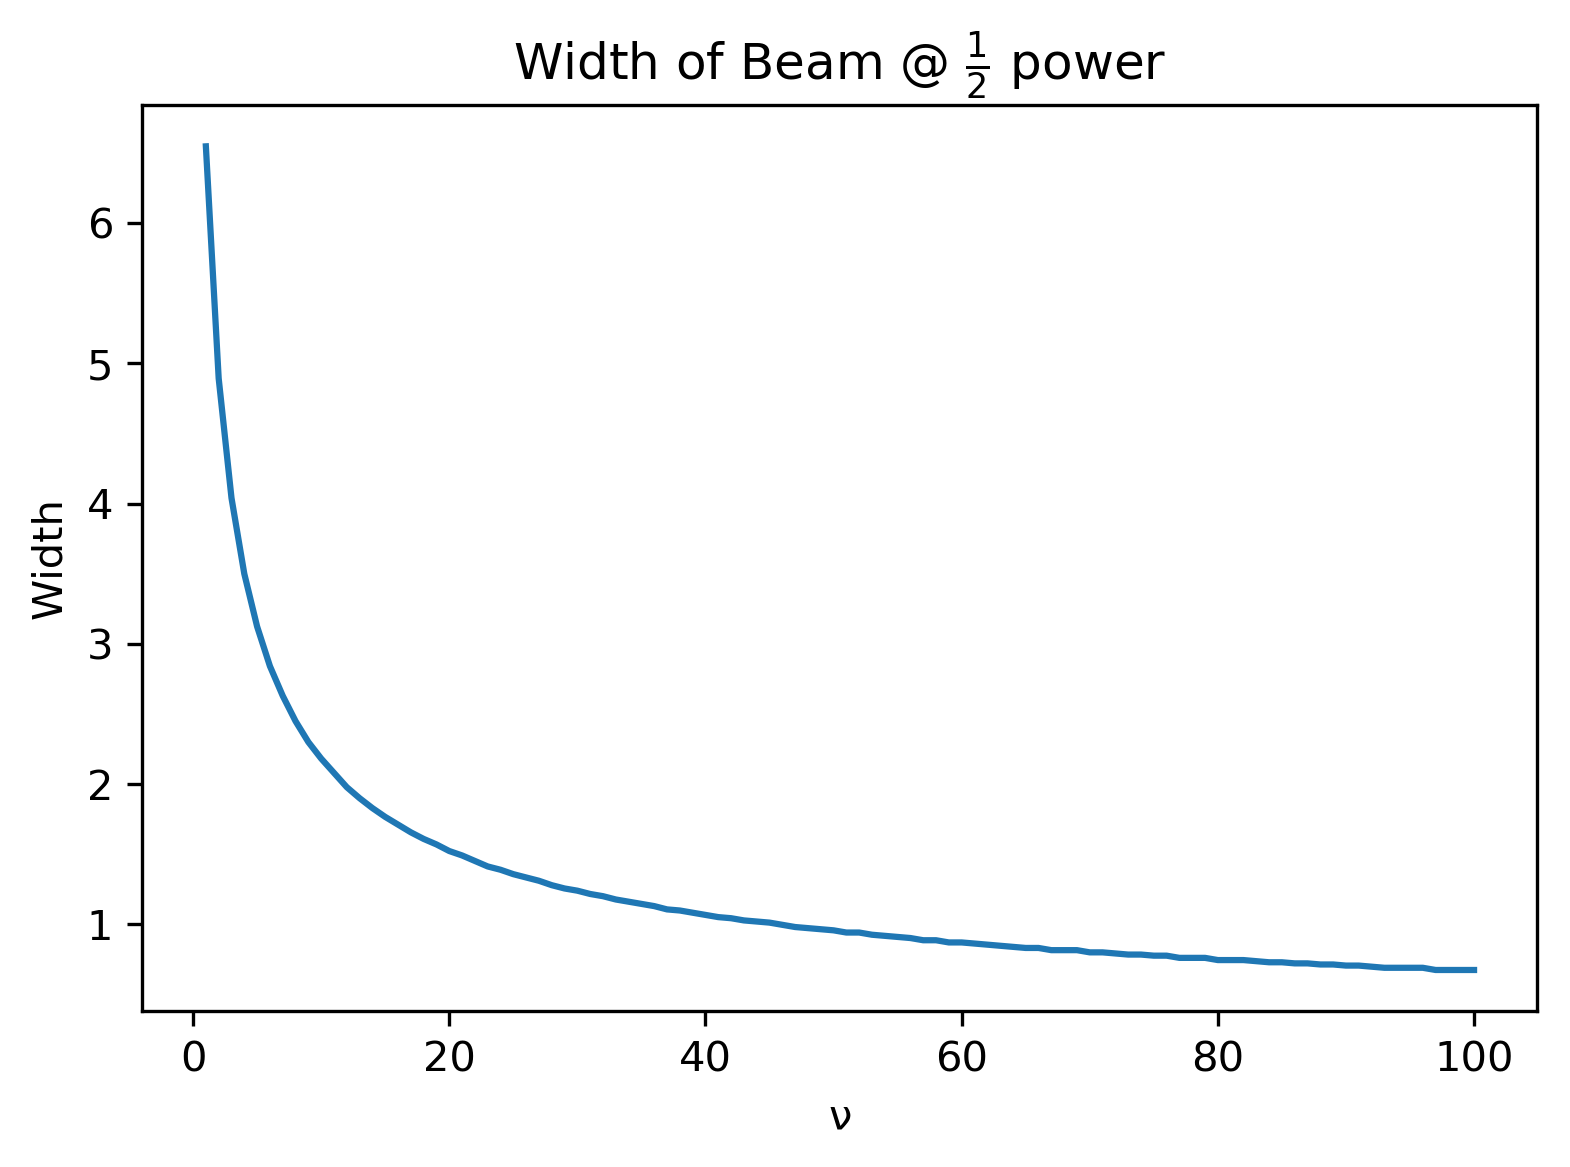

In [32]:
# Trying to use the information in http://www.bebec.eu/Downloads/BeBeC2014/Papers/BeBeC-2014-01.pdf
N = 7                            # Number of antenna
λ = 1                            # Wavelength
num_points = 10000
practically_zero_dB = 0.05
θs = np.linspace(0,π,num_points)
beam_θ = 5*π/7                     # Desired azmith angle
ak = calc_coeffs(beam_θ,N,r,λ)
s_k = 50                         # Alice's signal strength
g_k = np.array(ak).reshape(1,N)  # Direction of Alice's transmitter relative to Bob (in this case, beam_θ)
b = lambda g,n=1 : s_k*(float(g_k@g))**(2*n)
C = s_k*(np.dot(g_k.T,g_k))      # Cross Spectral Matrix
res1 = [b(calc_coeffs(θ,N,s_k,λ)) for θ in θs]
νs = np.arange(1,101,1)
percs = []
bd_ws = []
for i in νs :
    res2 = []
    for θ in θs :
        steer_coeffs = calc_coeffs(θ,N,s_k,λ)
        res2.append(b(steer_coeffs,i))
    '''
    mask = np.array(res2) <= practically_zero_dB
    percs.append(sum(mask)/num_points*100)
    '''
    bd_mask = list(np.array(res2) >= s_k/2)
    ind1 = bd_mask.index(True)
    ind2 = bd_mask[ind1:].index(False) + ind1 - 1 # Do a small example to see why this is true.
    bd_angle = θs[ind2] - θs[ind1]
    bd_ws.append(np.sin(bd_angle)*s_k/(2*np.sin((π-bd_angle)/2)))
plt.plot(νs,bd_ws)
plt.title(r'Width of Beam @ $\frac{1}{2}$ power')
plt.xlabel('ν')
plt.ylabel('Width')
plt.show()